In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.ramsey as ramsey
import analysis.plotting as plotting
import analysis.analysis as analysis
import classifiers.classifier as classifier
import joblib
from scipy.optimize import minimize

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")


Qubit(ef_half_amp=1.3, ef_ssm=-0.25684, IQ_angle=60, ro_dur=5000, RO_LO=6.6247, qubit_id=q1, mixer_offset_ef=6, RO_IF=None, mixer_offset_ge=2.5, ef_half_time=25, ge_amp=1.01, RO_LO_pwr=16, ef_amp=1.5, ro_amp=0.25, ge_time=77, ro_freq=6.72739, ROIF=0.10268999999999995, ef_time=44, qubit_thr=[-10000, -600], ge_ssm=-0.1144)
Qubit(ef_half_amp=None, ef_ssm=-0.2962, IQ_angle=25, ro_dur=5000, RO_LO=6.6247, qubit_id=q2, mixer_offset_ef=None, RO_IF=None, mixer_offset_ge=None, ef_half_time=None, ge_amp=0.4, RO_LO_pwr=16, ef_amp=1, ro_amp=0.45, ge_time=74, ro_freq=6.65554, ROIF=0.030840000000000423, ef_time=None, qubit_thr=[-10000, 1900], ge_ssm=-0.154)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)

In [9]:
def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [4]:
def run_echo(
    q1,
    q2,
    general_vals_dict,
    num_steps:int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
   
    # Run the experiment
    swap_freq=-0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    ramsey.echo_ef(q1, q2, general_vals_dict,num_steps, sweep_time,swap_time,swap_freq,verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    return values, IQ_df,df_prob

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 23.747367 sec
Captured 66 buffers (2.779256 buffers per sec)
Captured 202752 records (8537.872971 records per sec)
Transferred 3321888768 bytes (139884510.759040 bytes per sec)


<Figure size 800x800 with 0 Axes>

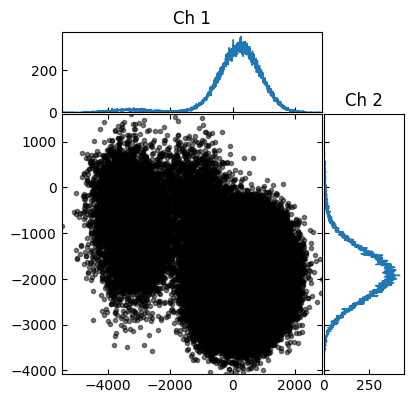

<Figure size 800x800 with 0 Axes>

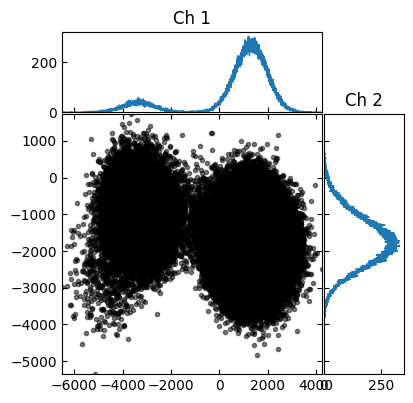

In [5]:
reps = 2000
sweep_time = 10000
num_steps = 101
# q1.ef_ssm=-0.257
values, IQ_df,df_prob= run_echo(q1,q2,general_vals_dict,num_steps, sweep_time, reps)

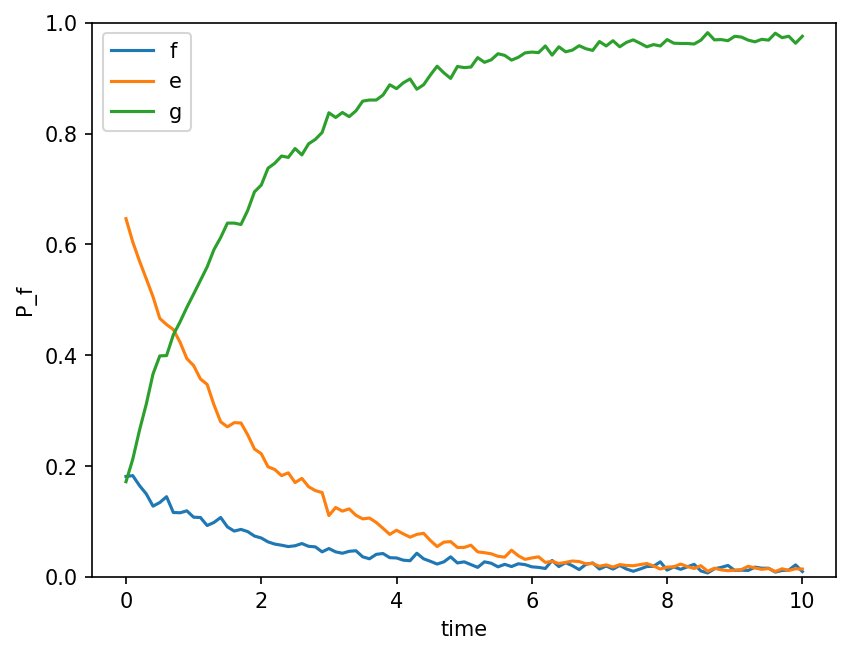

In [6]:
plt.figure(dpi=150)
sns.lineplot(data=df_prob, x="time", y="P_f", label="f")
sns.lineplot(data=df_prob, x="time", y="P_e", label="e")
sns.lineplot(data=df_prob, x="time", y="P_g", label="g")
plt.ylim(0, 1)
plt.legend()
plt.show()

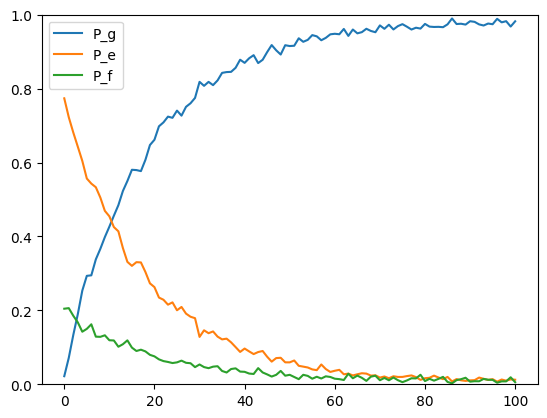

(0.0, 1.0)

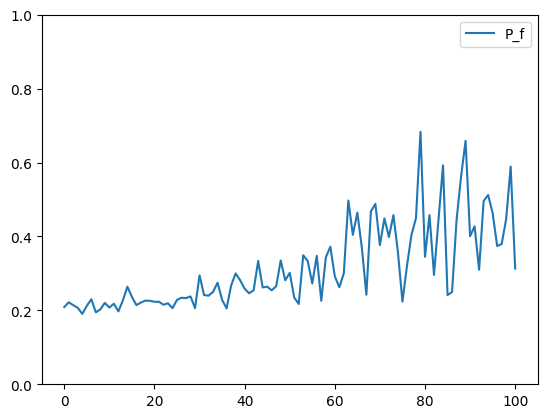

In [12]:

scale_matrix= joblib.load("classifiers/scale_matrix.pkl")
scale_matrix_inv = np.linalg.inv(scale_matrix)
P_matrix_plus=np.array([df_prob["P_g"], df_prob["P_e"], df_prob["P_f"]])
P_matrix_plus_scaled =correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,7)###b##bayesian_unfolding(scale_matrix, P_matrix_plus,14)###########correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,4)#scale_matrix_inv@P_matrix_plus#bayesian_unfolding(scale_matrix, P_matrix_plus,11)##@##correct_probabilities_over_time(scale_matrix, P_matrix_plus)#bayesian_unfolding(scale_matrix, P_matrix_plus,7)

normalized_sclaed_f_plus=P_matrix_plus_scaled[2]/(P_matrix_plus_scaled[1]+P_matrix_plus_scaled[2])
plt.plot(P_matrix_plus_scaled[0], label="P_g")
plt.plot(P_matrix_plus_scaled[1], label="P_e")
plt.plot(P_matrix_plus_scaled[2], label="P_f") 
plt.ylim(0, 1)
plt.legend()

plt.show()
sns.lineplot(data=normalized_sclaed_f_plus, label="P_f")
plt.ylim(0, 1)

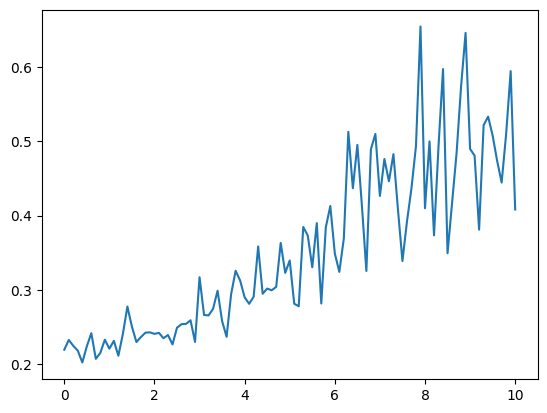

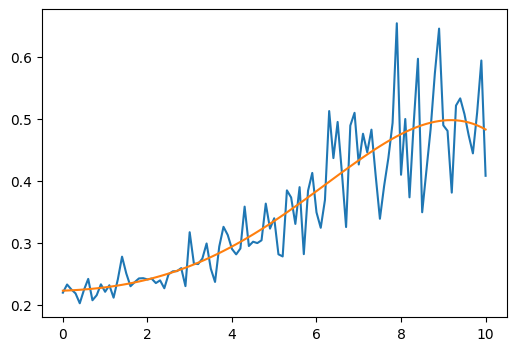



  freq: 0.05162202926479276 +/- 0.02067652686650464
 gamma: -0.23080142262009368 +/- 0.24307981754938698
   amp: -0.036848787237091875 +/- 0.048261012587175384
 phase: 494.8916417768931 +/- 108.2924953068907
offset: 0.2485421627693806 +/- 0.09587832946450134
pi_pulse time: 9.68578738807949 +/- 0.02067652686650464
T2* = -4.33272892622517 μs


In [8]:
P_f_norm= df_prob["P_f"] / (df_prob["P_f"]+df_prob["P_e"])
plt.plot(df_prob["time"],P_f_norm)
plt.show()
T2_fit_vals,_,_,_ = analysis.fit_sine_decay(df_prob["time"],P_f_norm,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))